In [1]:
import csv

# Load captions from the caption.txt file
image_caption_mapping = {}

# Assuming caption.txt is in the same directory
with open('/kaggle/input/flickr8k/captions.txt', 'r') as f:
    reader = csv.reader(f)
    next(reader)  # Skip header

    for row in reader:
        image_file, caption = row
        if image_file in image_caption_mapping:
            image_caption_mapping[image_file].append(caption)
        else:
            image_caption_mapping[image_file] = [caption]

# Verify loading
print(image_caption_mapping['1000268201_693b08cb0e.jpg'])


['A child in a pink dress is climbing up a set of stairs in an entry way .', 'A girl going into a wooden building .', 'A little girl climbing into a wooden playhouse .', 'A little girl climbing the stairs to her playhouse .', 'A little girl in a pink dress going into a wooden cabin .']


In [2]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import os
import random

class MultiCaptionCLIPDataset(Dataset):
    def __init__(self, image_caption_dict, image_dir, processor, max_length=77):
        self.image_caption_dict = image_caption_dict
        self.image_dir = image_dir
        self.processor = processor
        self.max_length = max_length
        self.image_files = list(image_caption_dict.keys())

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_file = self.image_files[idx]
        image_path = os.path.join(self.image_dir, image_file)
        image = Image.open(image_path).convert('RGB')
        
        # Randomly select one of the five captions
        caption = random.choice(self.image_caption_dict[image_file])

        # Process the image and text
        inputs = self.processor(text=[caption], images=image, return_tensors="pt", padding="max_length", max_length=self.max_length, truncation=True)
        
        # Remove the batch dimension
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}
        
        return inputs

In [3]:
import torch.nn.functional as F
def contrastive_loss(logits_per_image, logits_per_text):
    labels = torch.arange(len(logits_per_image)).to(logits_per_image.device)
    loss_i = F.cross_entropy(logits_per_image, labels)
    loss_t = F.cross_entropy(logits_per_text, labels)
    return (loss_i + loss_t) / 2.0

In [4]:
import torch
from torch.utils.data import DataLoader, random_split
from transformers import CLIPProcessor, CLIPModel
from tqdm import tqdm

model_name = "openai/clip-vit-base-patch32"
model = CLIPModel.from_pretrained(model_name)
processor = CLIPProcessor.from_pretrained(model_name)

# Create dataset and dataloader
dataset = MultiCaptionCLIPDataset(image_caption_mapping, image_dir="/kaggle/input/flickr8k/Images", processor=processor)
# Define the split ratio for training and validation
train_size = int(0.8 * len(dataset))  # 80% training
val_size = len(dataset) - train_size  # 20% validation

# Split the dataset into training and validation sets
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders for training and validation
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)


optimizer = torch.optim.AdamW(model.parameters(), lr=5e-8)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e

In [5]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"


save_directory = "/kaggle/working/fine_tuned_clip_model"
os.makedirs(save_directory, exist_ok=True)

num_epochs = 10

# Early stopping parameters
patience = 3 
best_val_loss = float('inf')
epochs_without_improvement = 0

# Training loop
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    
    # Training step
    for batch in tqdm(train_dataloader, desc=f"Epoch {epoch + 1} [Training]"):
        # Move batch to device
        batch = {k: v.to(device) for k, v in batch.items()}
        
        # Forward pass
        outputs = model(**batch)
        
        # Calculate loss manually
        logits_per_image = outputs.logits_per_image
        logits_per_text = outputs.logits_per_text
        loss = contrastive_loss(logits_per_image, logits_per_text)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch + 1}, Average Training Loss: {avg_train_loss:.4f}")
    
    # Validation step
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in tqdm(val_dataloader, desc=f"Epoch {epoch + 1} [Validation]"):
            # Move batch to device
            batch = {k: v.to(device) for k, v in batch.items()}
            
            # Forward pass
            outputs = model(**batch)
            
            # Calculate loss manually
            logits_per_image = outputs.logits_per_image
            logits_per_text = outputs.logits_per_text
            loss = contrastive_loss(logits_per_image, logits_per_text)
            
            total_val_loss += loss.item()
    
    avg_val_loss = total_val_loss / len(val_dataloader)
    print(f"Epoch {epoch + 1}, Average Validation Loss: {avg_val_loss:.4f}")
    
    # Check if validation loss improved
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        for param in model.parameters():
            param.data = param.data.contiguous()
        # Save the best model
        model.save_pretrained(save_directory)
        processor.save_pretrained(save_directory)
        print(f"Best model saved with validation loss: {avg_val_loss:.4f}")
    else:
        epochs_without_improvement += 1
    
    # Early stopping condition
    if epochs_without_improvement >= patience:
        print("Early stopping triggered!")
        break


Epoch 1 [Training]:   0%|          | 0/203 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch 1 [Training]: 100%|██████████| 203/203 [01:01<00:00,  4.19it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch 1 [Training]: 100%|██████████| 203/203 [01:01<00:00,  3.29it/s]


Epoch 1, Average Training Loss: 0.2278


Epoch 1 [Validation]: 100%|██████████| 51/51 [00:08<00:00,  5.77it/s]


Epoch 1, Average Validation Loss: 0.2196
Best model saved with validation loss: 0.2196


Epoch 2 [Training]: 100%|██████████| 203/203 [01:00<00:00,  3.34it/s]


Epoch 2, Average Training Loss: 0.2006


Epoch 2 [Validation]: 100%|██████████| 51/51 [00:07<00:00,  6.88it/s]


Epoch 2, Average Validation Loss: 0.1934
Best model saved with validation loss: 0.1934


Epoch 3 [Training]: 100%|██████████| 203/203 [01:00<00:00,  3.34it/s]


Epoch 3, Average Training Loss: 0.1891


Epoch 3 [Validation]: 100%|██████████| 51/51 [00:07<00:00,  6.87it/s]


Epoch 3, Average Validation Loss: 0.1946


Epoch 4 [Training]: 100%|██████████| 203/203 [01:00<00:00,  3.34it/s]


Epoch 4, Average Training Loss: 0.1753


Epoch 4 [Validation]: 100%|██████████| 51/51 [00:07<00:00,  7.10it/s]


Epoch 4, Average Validation Loss: 0.1768
Best model saved with validation loss: 0.1768


Epoch 5 [Training]: 100%|██████████| 203/203 [01:00<00:00,  3.33it/s]


Epoch 5, Average Training Loss: 0.1731


Epoch 5 [Validation]: 100%|██████████| 51/51 [00:07<00:00,  6.90it/s]


Epoch 5, Average Validation Loss: 0.1768


Epoch 6 [Training]: 100%|██████████| 203/203 [01:01<00:00,  3.33it/s]


Epoch 6, Average Training Loss: 0.1715


Epoch 6 [Validation]: 100%|██████████| 51/51 [00:07<00:00,  6.93it/s]


Epoch 6, Average Validation Loss: 0.1689
Best model saved with validation loss: 0.1689


Epoch 7 [Training]: 100%|██████████| 203/203 [01:01<00:00,  3.31it/s]


Epoch 7, Average Training Loss: 0.1529


Epoch 7 [Validation]: 100%|██████████| 51/51 [00:07<00:00,  7.02it/s]


Epoch 7, Average Validation Loss: 0.1786


Epoch 8 [Training]: 100%|██████████| 203/203 [01:00<00:00,  3.33it/s]


Epoch 8, Average Training Loss: 0.1562


Epoch 8 [Validation]: 100%|██████████| 51/51 [00:07<00:00,  6.95it/s]


Epoch 8, Average Validation Loss: 0.1372
Best model saved with validation loss: 0.1372


Epoch 9 [Training]: 100%|██████████| 203/203 [01:00<00:00,  3.33it/s]


Epoch 9, Average Training Loss: 0.1552


Epoch 9 [Validation]: 100%|██████████| 51/51 [00:07<00:00,  6.84it/s]


Epoch 9, Average Validation Loss: 0.1627


Epoch 10 [Training]: 100%|██████████| 203/203 [01:01<00:00,  3.32it/s]


Epoch 10, Average Training Loss: 0.1552


Epoch 10 [Validation]: 100%|██████████| 51/51 [00:08<00:00,  6.35it/s]


Epoch 10, Average Validation Loss: 0.1490


Epoch 11 [Training]: 100%|██████████| 203/203 [01:00<00:00,  3.33it/s]


Epoch 11, Average Training Loss: 0.1417


Epoch 11 [Validation]: 100%|██████████| 51/51 [00:07<00:00,  6.85it/s]


Epoch 11, Average Validation Loss: 0.1559
Early stopping triggered!


In [6]:

torch.save(model.state_dict(), os.path.join(save_directory, 'pytorch_model.bin'))
processor.save_pretrained(save_directory)

print(f"Model state dictionary saved manually to {save_directory}")


Model state dictionary saved manually to /kaggle/working/fine_tuned_clip_model


In [7]:
import torch
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import os
import numpy as np


model_dir = "/kaggle/working/fine_tuned_clip_model"
model = CLIPModel.from_pretrained(model_dir)
processor = CLIPProcessor.from_pretrained(model_dir)

model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

test_image_dir = "/kaggle/input/dog-boy"
test_captions = [
    "A child playing with a dog.",
    "A dog running in the park.",
    "A family having a picnic in the yard.",
    "A bird is flying.",
    "A child is standing."
]

# Create a list of test image files
test_image_files = os.listdir(test_image_dir)

# Function to compute cosine similarity between image and text embeddings
def compute_cosine_similarity(image_embeds, text_embeds):
    # Normalize the embeddings (L2 normalization)
    image_embeds = image_embeds / image_embeds.norm(dim=-1, keepdim=True)
    text_embeds = text_embeds / text_embeds.norm(dim=-1, keepdim=True)
    
    # Compute the cosine similarity (dot product of normalized vectors)
    cosine_similarity = torch.matmul(image_embeds, text_embeds.T)
    return cosine_similarity

# Function to test model on an image with provided captions and get cosine similarity
def test_model_on_image(image_path, captions):
    image = Image.open(image_path).convert("RGB")

    # Process the image and the provided captions
    inputs = processor(text=captions, images=image, return_tensors="pt", padding=True).to(device)

    # Forward pass through the model
    with torch.no_grad():
        outputs = model(**inputs)

    # Get image and text embeddings
    image_embeds = outputs.image_embeds
    text_embeds = outputs.text_embeds

    # Compute cosine similarity
    cosine_similarities = compute_cosine_similarity(image_embeds, text_embeds)
    cosine_similarities = cosine_similarities.squeeze(0).cpu().numpy()

    # Print cosine similarity scores for each caption
    for i, caption in enumerate(captions):
        print(f"Cosine similarity score for '{caption}': {cosine_similarities[i]}")

    # Get the most similar caption based on the highest cosine similarity score
    most_similar_caption_idx = np.argmax(cosine_similarities)
    most_similar_caption = captions[most_similar_caption_idx]

    return most_similar_caption, cosine_similarities

In [8]:
# Loop through test images and run inference
for image_file in test_image_files:
    image_path = os.path.join(test_image_dir, image_file)
    predicted_caption, similarity_scores = test_model_on_image(image_path, test_captions)
    print(f"Image: {image_file}")
    print(f"Predicted Caption: '{predicted_caption}'")


Cosine similarity score for 'A child playing with a dog.': 0.2898597717285156
Cosine similarity score for 'A dog running in the park.': 0.27569055557250977
Cosine similarity score for 'A family having a picnic in the yard.': 0.19230404496192932
Cosine similarity score for 'A bird is flying.': 0.1915186494588852
Cosine similarity score for 'A child is standing.': 0.22093670070171356
Image: dog_boy.jpg
Predicted Caption: 'A child playing with a dog.'


## Faiss Vector DataBase

In [9]:
!pip install faiss-gpu
!pip install faiss-cpu

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 18.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 5.6 MB/s eta 0:00:0000:0100:01m


In [10]:
import os
from PIL import Image
import torch
import numpy as np

def extract_image_embeddings(image_caption_mapping, image_dir, model, processor, device):
    image_embeddings = []
    image_files = []
    
    for image_file in image_caption_mapping.keys():
        image_path = os.path.join(image_dir, image_file)
        image = Image.open(image_path).convert("RGB")
        inputs = processor(images=image, return_tensors="pt").to(device)
        
        with torch.no_grad():
            outputs = model.get_image_features(**inputs)
        
        # Move embedding to CPU and convert to numpy array
        image_embedding = outputs.cpu().numpy()
        image_embeddings.append(image_embedding)
        image_files.append(image_file)  # Keep track of corresponding image files
    
    # Stack embeddings into a matrix (num_images, embedding_dim)
    image_embeddings = np.vstack(image_embeddings)
    
    return image_embeddings, image_files

# Extract image embeddings
image_embeddings, image_files = extract_image_embeddings(image_caption_mapping, image_dir="/kaggle/input/flickr8k/Images", model=model, processor=processor, device=device)


In [11]:
def extract_text_embeddings(image_caption_mapping, model, processor, device):
    text_embeddings = []
    
    for image_file, captions in image_caption_mapping.items():
        caption_embeds = []
        for caption in captions:
            inputs = processor(text=[caption], return_tensors="pt").to(device)
            
            with torch.no_grad():
                outputs = model.get_text_features(**inputs)
            
            # Move embedding to CPU and convert to numpy array
            caption_embedding = outputs.cpu().numpy()
            caption_embeds.append(caption_embedding)
        
        # Average the embeddings of all 5 captions for the image
        avg_caption_embedding = np.mean(caption_embeds, axis=0)
        text_embeddings.append(avg_caption_embedding)
    
    text_embeddings = np.vstack(text_embeddings)
    
    return text_embeddings

# Extract text embeddings
text_embeddings = extract_text_embeddings(image_caption_mapping, model, processor, device)


In [12]:
import faiss

# Dimensionality of the embedding vectors
d = image_embeddings.shape[1]  # Assuming image and text embeddings are of the same dimension

# Create FAISS index (IndexFlatL2 for Euclidean distance or IndexFlatIP for cosine similarity)
faiss_index = faiss.IndexFlatL2(d)  # Or use faiss.IndexFlatIP(d) for cosine similarity

# Add image embeddings to FAISS
faiss_index.add(image_embeddings)

print(f"Added {faiss_index.ntotal} image embeddings to the index.")


Added 8091 image embeddings to the index.


In [18]:
import matplotlib.pyplot as plt
from PIL import Image
def show_images(results, image_dir):
    """Display images based on search results."""
    fig, axes = plt.subplots(1, len(results), figsize=(15, 4))
    
    if len(results) == 1:
        axes = [axes]  # Handle case when there's only one result
    
    for i, (image_file, distance) in enumerate(results):
        image_path = os.path.join(image_dir, image_file)
        image = Image.open(image_path)
        
        # Display image
        axes[i].imshow(image)
        axes[i].set_title(f"{image_file}\nDistance: {distance:.4f}")
        axes[i].axis('off')
    
    plt.show()

Image: 539761097_5c6c70425b.jpg, Distance: 108.94375610351562
Image: 489773343_a8aecf7db3.jpg, Distance: 110.39674377441406
Image: 3446347599_0ecc49a9d5.jpg, Distance: 110.72541809082031
Image: 307321761_606fc91673.jpg, Distance: 111.61474609375
Image: 2521062020_f8b983e4b2.jpg, Distance: 112.50004577636719


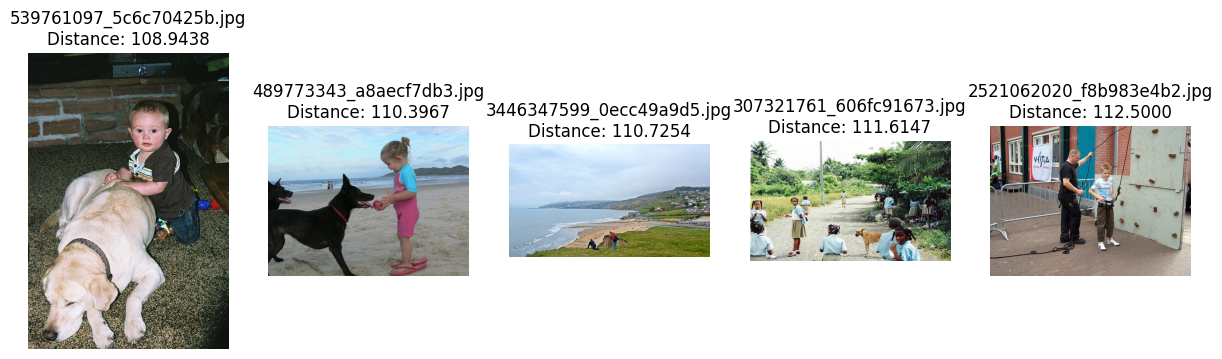

In [19]:
def search_by_text(query_text, model, processor, faiss_index, image_files, image_dir, top_k=5):
    # Process the query text
    inputs = processor(text=[query_text], return_tensors="pt", padding=True).to(device)
    
    with torch.no_grad():
        text_embedding = model.get_text_features(**inputs).cpu().numpy()

    # Search FAISS index for the most similar images
    distances, indices = faiss_index.search(text_embedding, top_k)

    # Retrieve corresponding image file paths
    results = [(image_files[idx], distances[0][i]) for i, idx in enumerate(indices[0])]
    
    # Display results
    for result in results:
        print(f"Image: {result[0]}, Distance: {result[1]}")
    
    # Show the retrieved images
    show_images(results, image_dir)

# Example text query search
search_by_text("A child playing with a dog", model, processor, faiss_index, image_files, image_dir="/kaggle/input/flickr8k/Images")

Image: 2472634822_7d5d2858c0.jpg, Distance: 39.807106018066406
Image: 2509824208_247aca3ea3.jpg, Distance: 49.443458557128906
Image: 3467941308_ae6989e29c.jpg, Distance: 51.07609558105469
Image: 3106883334_419f3fb16f.jpg, Distance: 52.00444793701172
Image: 3030824089_e5a840265e.jpg, Distance: 54.29974365234375


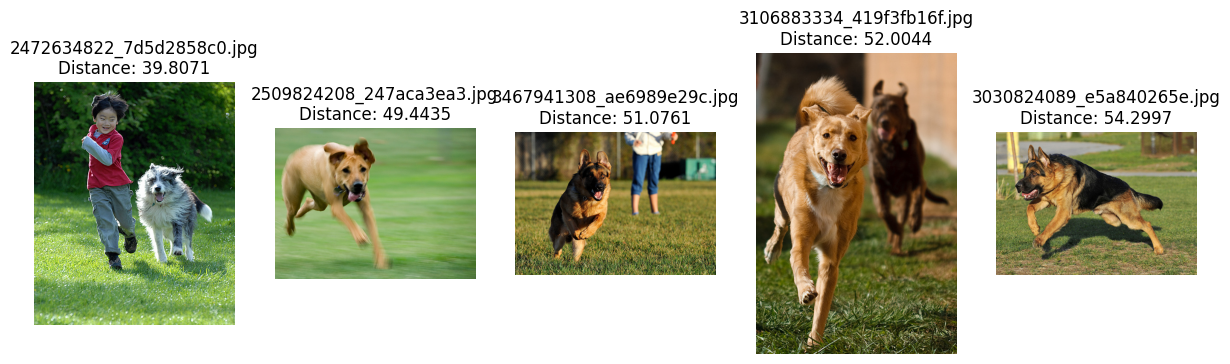

In [20]:
def search_by_image(query_image_path, model, processor, faiss_index, image_files, image_dir, top_k=5):
    # Load and process the query image
    query_image = Image.open(query_image_path).convert("RGB")
    inputs = processor(images=query_image, return_tensors="pt").to(device)

    # Get the embedding for the image query
    with torch.no_grad():
        query_image_embedding = model.get_image_features(**inputs).cpu().numpy()

    # Search FAISS index for the most similar images
    distances, indices = faiss_index.search(query_image_embedding, top_k)

    # Retrieve corresponding image file paths
    results = [(image_files[idx], distances[0][i]) for i, idx in enumerate(indices[0])]
    
    # Display results
    for result in results:
        print(f"Image: {result[0]}, Distance: {result[1]}")
    
    # Show the retrieved images
    show_images(results, image_dir)

# Example image query search
search_by_image("/kaggle/input/dog-boy/dog_boy.jpg", model, processor, faiss_index, image_files, image_dir="/kaggle/input/flickr8k/Images")


## Testing

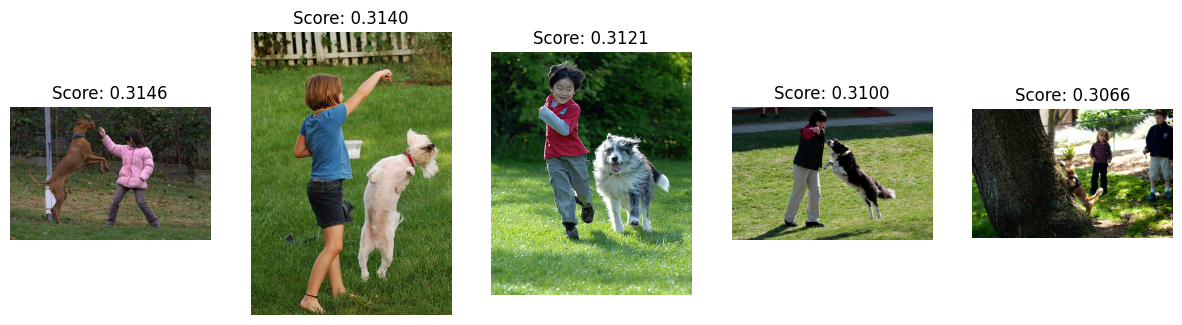

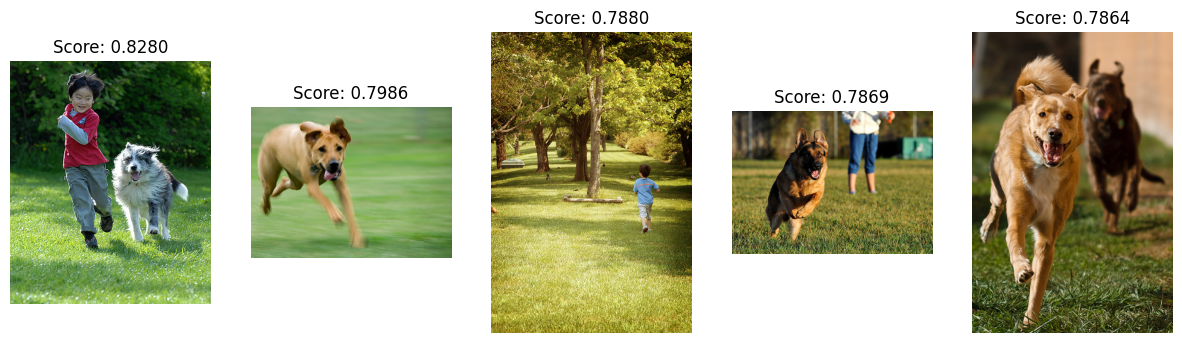

In [21]:
# Normalize embeddings to unit vectors for cosine similarity
image_embeddings_normalized = image_embeddings / np.linalg.norm(image_embeddings, axis=1, keepdims=True)

# FAISS setup: Index with cosine similarity (Inner product search on normalized vectors)
dimension = image_embeddings_normalized.shape[1]
index = faiss.IndexFlatIP(dimension)
index.add(image_embeddings_normalized)

# Function to compute text embedding
def get_text_embedding(text, model, processor):
    inputs = processor(text=[text], return_tensors="pt", padding=True).to(device)
    with torch.no_grad():
        text_embedding = model.get_text_features(**inputs).cpu().numpy()
    return text_embedding / np.linalg.norm(text_embedding, axis=1, keepdims=True)

# Function to compute image embedding for search
def get_image_embedding(image_path, model, processor):
    image = Image.open(image_path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt").to(device)
    with torch.no_grad():
        image_embedding = model.get_image_features(**inputs).cpu().numpy()
    return image_embedding / np.linalg.norm(image_embedding, axis=1, keepdims=True)

# Function to search the FAISS index
def search_faiss(embedding, index, image_files, top_k=5):
    distances, indices = index.search(embedding, top_k)
    distances = distances.squeeze(0)  # (top_k,)
    indices = indices.squeeze(0)  # (top_k,)
    
    results = [(image_files[idx], distances[i]) for i, idx in enumerate(indices)]
    return results

# Function to display images with similarity scores
def show_images(results, image_dir):
    fig, axes = plt.subplots(1, len(results), figsize=(15, 5))
    for i, (image_file, score) in enumerate(results):
        image_path = os.path.join(image_dir, image_file)
        image = Image.open(image_path)
        axes[i].imshow(image)
        axes[i].set_title(f"Score: {score:.4f}")
        axes[i].axis('off')
    plt.show()

# Search by text
query_text = "A child playing with a dog"
text_embedding = get_text_embedding(query_text, model, processor)
text_results = search_faiss(text_embedding, index, image_files, top_k=5)
show_images(text_results, image_dir='/kaggle/input/flickr8k/Images')

# Search by image
query_image_path = "/kaggle/input/dog-boy/dog_boy.jpg"
image_embedding = get_image_embedding(query_image_path, model, processor)
image_results = search_faiss(image_embedding, index, image_files, top_k=5)
show_images(image_results, image_dir='/kaggle/input/flickr8k/Images')

In [22]:
import faiss

# Assuming 'index' is your FAISS index object
faiss.write_index(index, "faiss_index.bin")
